Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/10 17:25:05 WARN Utils: Your hostname, gpuana02, resolves to a loopback address: 127.0.1.1; using 192.168.1.216 instead (on interface enp4s0)
26/01/10 17:25:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/10 17:25:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/10 17:25:06 WARN RapidsPluginUtils: RAPIDS Accelerator 25.10.0 using cudf 25.10.0, private revision 28e7c65b3c0526baba384d9b97ee12e4d6766d9a
26/01/10 17:25:06 WARN RapidsPluginUtils: RAPIDS Accelerator is enabled, to disable GPU support set `spark.rapids.sql.enabled` to false.


Statistics:
[[    0.     0.     0.]
 [    0. 83355.     0.]
 [    0.     0.     0.]]
-30.0 10.0 240
./prm/dc31_x1_drift_calib_data.csv
ファイル './prm/dc31_x1_drift_calib_data.csv' に保存しました。
Statistics:
[[    0.     0.     0.]
 [    0. 83820.     0.]
 [    0.     0.     0.]]
-30.0 10.0 240
./prm/dc31_x2_drift_calib_data.csv
ファイル './prm/dc31_x2_drift_calib_data.csv' に保存しました。
Statistics:
[[    0.     0.     0.]
 [    0. 78967.     0.]
 [    0.     0.     0.]]
-30.0 10.0 240
./prm/dc31_y1_drift_calib_data.csv
ファイル './prm/dc31_y1_drift_calib_data.csv' に保存しました。
Statistics:
[[    0.     0.     0.]
 [    0. 81488.     0.]
 [    0.     0.     0.]]
-30.0 10.0 240
./prm/dc31_y2_drift_calib_data.csv
ファイル './prm/dc31_y2_drift_calib_data.csv' に保存しました。
Statistics:
[[    0.     0.     0.]
 [    0. 83341.     0.]
 [    0.     0.     0.]]
-30.0 10.0 240
./prm/dc31_x3_drift_calib_data.csv
ファイル './prm/dc31_x3_drift_calib_data.csv' に保存しました。
Statistics:
[[    0.     0.     0.]
 [    0. 83801.     0.]
 [    0.  

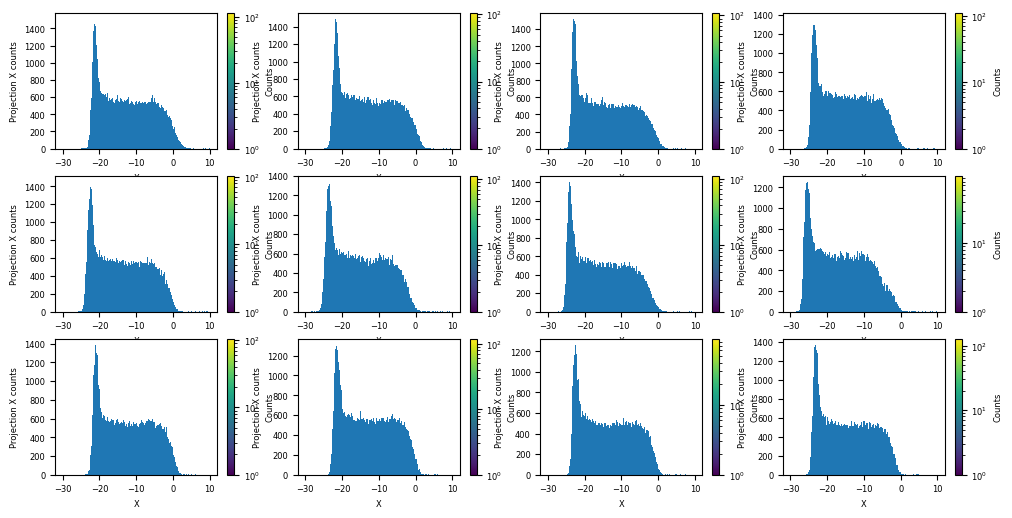

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from matplotlib import pyplot as plt
from hist.sparkHist2d import Hist2D
from hist.projection import ProjectionX
from matplotlib.colors import LogNorm


from make_MWDC_prm import drift_calib_data

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("run1011_mwdc.parquet")

planes = ['dc31_x1','dc31_x2','dc31_y1','dc31_y2','dc31_x3','dc31_x4','dc31_y3','dc31_y4','dc32_x1','dc32_x2','dc32_y1','dc32_y2']
dc31_charge_range = [50,150]
dc31_timing_range = [-30,10]
dc32_charge_range = [50,150]
dc32_timing_range = [-30,10]

plt.figure(0, figsize=(12,6))
plt.rcParams["font.size"] = 6
for i, plane in enumerate(planes):
    q, mod = divmod(i,4)
    ax =plt.subplot2grid((3,4),(q,mod))
    dfp = df.select(f"{plane}_id",f"{plane}_charge",f"{plane}_timing")
    dfp = dfp.withColumn("charge0",F.expr(f"element_at({plane}_charge, 1)")) \
             .withColumn("timing0",F.expr(f"element_at({plane}_timing,1)")) \
             .withColumn("id0",F.expr(f"element_at({plane}_id, 1)")) \
             .filter("id0>0 and id0<15")

    if "dc31" in plane:
        charge_range = dc31_charge_range
        timing_range = dc31_timing_range
    else:
        charge_range = dc32_charge_range
        timing_range = dc32_timing_range
    dfp = dfp.filter(F.expr(f"charge0 > {charge_range[0]} and charge0 < {charge_range[1]} and timing0 > {timing_range[0]} and timing0 < {timing_range[1]}"))
    H, xedges, yedges = Hist2D(dfp, ["timing0","charge0"],[240,240],[[-30,10],[50,150]],  interpolation='none', norm=LogNorm())
    ax.clear()
    Hpr, xedges_pr = ProjectionX(H, xedges, yedges)
    print(xedges_pr[0],xedges_pr[-1],len(xedges_pr))
    drift_calib_data(Hpr, f"./prm/{plane}_drift_calib_data.csv", h_range=(int(xedges_pr[0]), int(xedges_pr[-1])), nbin=len(xedges_pr)-1)
plt.show()